# Using imgui bundle scatter widget with Fiatlight

In [2]:
# cf  https://www.youtube.com/watch?v=STPv0jSAQEk&list=PLSIzlWDI17bS025ph6R0W_3RKM0qJ3qoO&index=4

# %pip install imgui_bundle

## Import dependencies

In [13]:
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pylab as plt 
from matplotlib.figure import Figure
import numpy as np
from enum import Enum
import pandas as pd

# Specific imports for fiatlight
import fiatlight as fl
from scatter_widget_bundle import ScatterData


## Use the widget

Here we simply show how to use the scatter widget with Fiatlight.
For this, we simply create a function `scatter_source(ScatterData) -> ScatterData`,  and we run it via Fiatlight.

Fiatlight will then let us enter the input data for this function.

Notes: 
- Fiatlight automatically saves the data: they will be saved into `fiat_settings/scatter_source.fiat_user_json` 
  (the filename scatter_source comes from the `app_name` below).

This means that upon restarting the kernel, the data will be loaded back in.

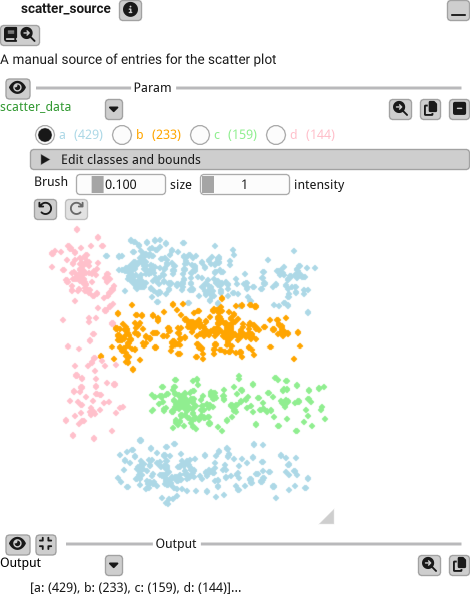

In [21]:
def scatter_source(scatter_data: ScatterData) -> ScatterData:
    """A manual source of entries for the scatter plot"""
    return scatter_data

fl.run(scatter_source, app_name="scatter_source")

## Input scatter data and draw a decision boundary from it

In this case, we will compose two functions: `scatter_source` and `plot_boundary` to draw a decision boundary from the input scatter data.

### Define `plot_boundary`

First we define `DecisionStrategy`, an enum with different strategies to draw the decision boundary.

Then we define `plot_boundary` that will take the scatter data and draw a decision boundary from it. It returns a matplotlib figure.
It accepts two parameters:
- strategy: the strategy to use to draw the boundary
- eps: the epsilon value to use for the decision boundary

In [23]:
class DecisionStrategy(Enum):
    """This is a simple enum to choose between logistic regression and decision tree
    Fiatlight will automatically convert this to radio buttons in the UI
    """
    logistic_regression = LogisticRegression
    decision_tree = DecisionTreeClassifier


@fl.with_fiat_attributes(eps__range = (0.01, 10))
def plot_boundary(df: pd.DataFrame, strategy: DecisionStrategy, eps: float=1.0) -> Figure | None:
    """This function will plot the decision boundary of a classifier on a 2D dataset
    * df is a DataFrame with columns 'x', 'y', 'color'
    * strategy is a DecisionStrategy enum (choose between logistic regression and decision tree)
    * eps is the step size in the meshgrid

    It is decorated with `@fl.with_fiat_attributes(eps__range = (0.01, 10))` which means that the 
    eps argument will be exposed in the UI as a slider with a range from 0.01 to 10.
    """
    if len(df) and (df['color'].nunique() > 1):
        X = df[['x', 'y']].values
        y = df['color']
        fig, ax = plt.subplots()
        if strategy == DecisionStrategy.logistic_regression:
            classifier = LogisticRegression().fit(X, y)
        else:
            classifier = DecisionTreeClassifier().fit(X, y)
        disp = DecisionBoundaryDisplay.from_estimator(
            classifier, X,
            response_method="predict_proba" if len(np.unique(df['color'])) == 2 else "predict",
            xlabel="x", ylabel="y",
            #alpha=0.5,
            eps=eps,
            ax=ax
        )
        disp.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
        ax.set_title(f"{classifier.__class__.__name__}")
        return fig
    else:
        return None


## Use plot_boundary with Fiatlight

We simply run a function composition with `scatter_source`, `scatter_data_to_df`, and `plot_boundary` to draw the decision boundary from the input scatter data.

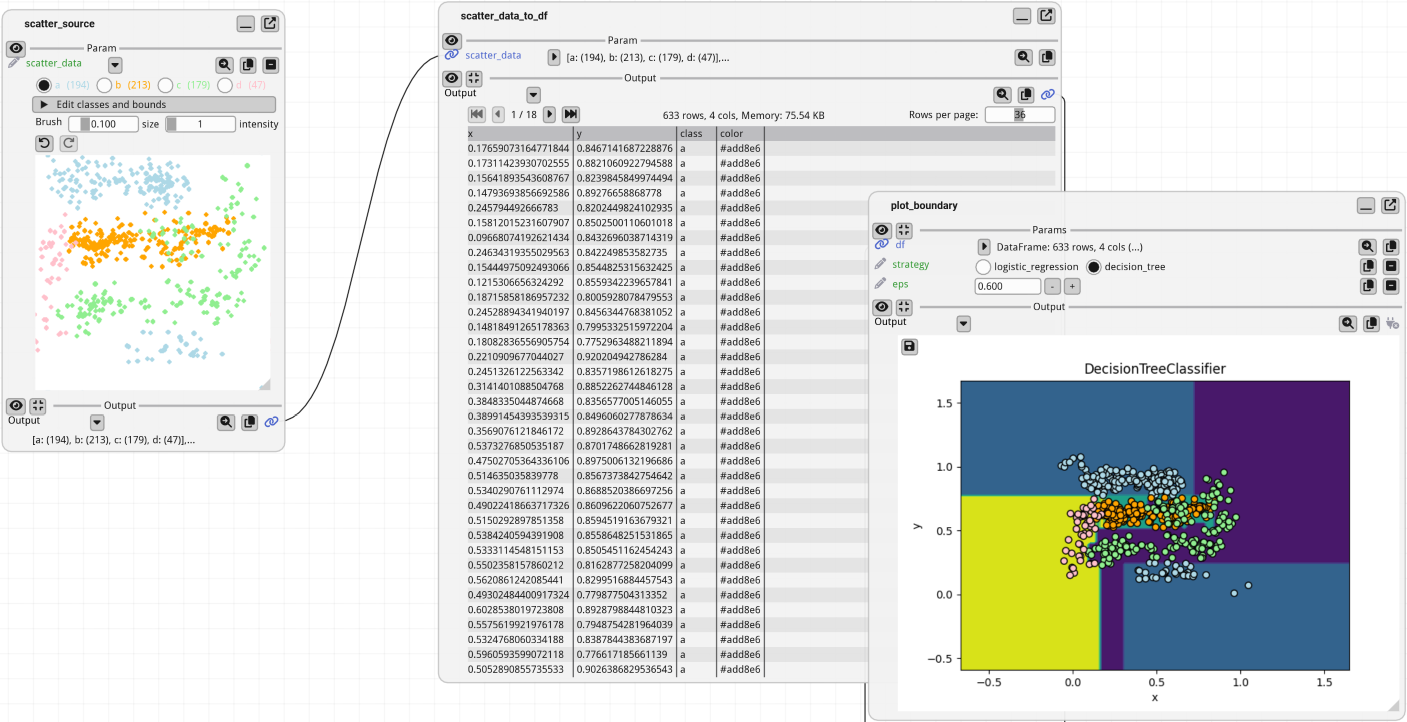

In [20]:
def scatter_data_to_df(scatter_data: ScatterData) -> pd.DataFrame:
    """Simple function to convert the scatter data to a DataFrame"""
    return scatter_data.data_as_pandas()


fl.run([scatter_source, scatter_data_to_df, plot_boundary], app_name="plot_boundary")

# How to get back data from Fiatlight

As we have seen, Fiatlight operates mostly with pure functions. Each call to fiatlight.run() before did save/reload its state, but it is inaccessible from the outside.

Pure functions are nice, but how do we get back the data from Fiatlight?

The answer is simple: we can define a sink function that will take the data and store it into a global variable.

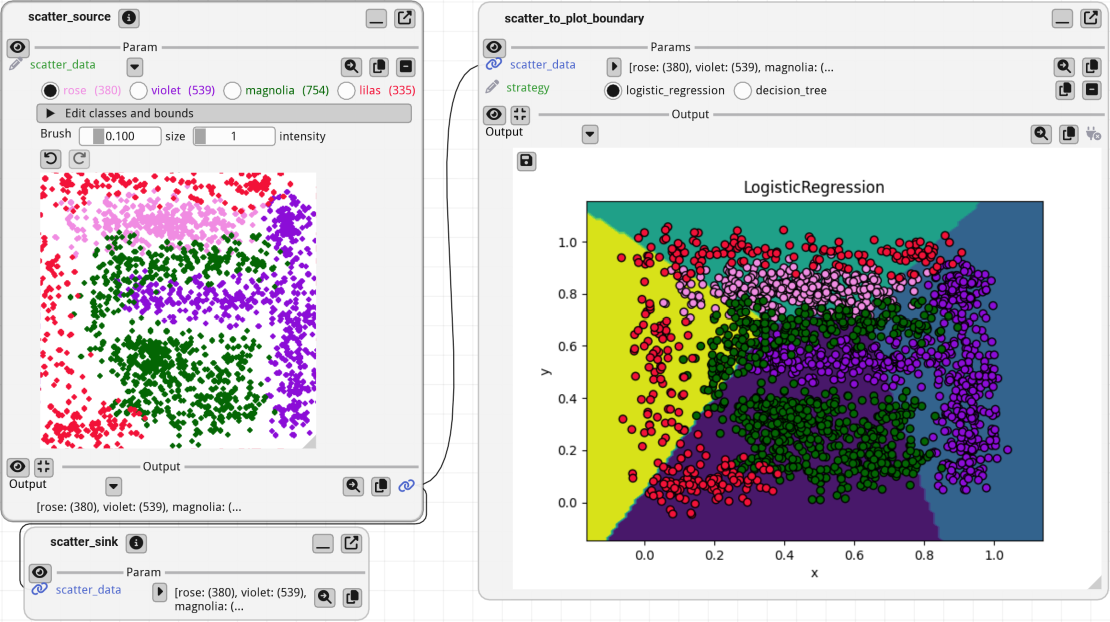

In [30]:
# Let's define a global variable to store the scatter data
SCATTER_DATA = ScatterData.make_default()

# And let's define a sink that will update this global variable
def scatter_sink(scatter_data: ScatterData) -> None:
    """This function does nothing but update the global variable SCATTER_DATA"""
    global SCATTER_DATA
    SCATTER_DATA = scatter_data

# Additionally, we will compose scatter_data_to_df, plot_boundary (to save space on the graph)
def scatter_to_plot_boundary(scatter_data: ScatterData, strategy: DecisionStrategy) -> Figure | None:
    return plot_boundary(scatter_data.data_as_pandas(), strategy=strategy, eps=0.1)

# And now let's define a slightly more complex function graph where we will add this sink
graph = fl.FunctionsGraph()
graph.add_function_composition([scatter_source, scatter_to_plot_boundary])
graph.add_function(scatter_sink)
graph.add_link(scatter_source, scatter_sink)
fl.run(graph, app_name="store_scatter_as_global")


**And now we have our global variable with the data!**

In [31]:
SCATTER_DATA.data_as_pandas()

,x,y,class,color
0,0.423197,0.784962,rose,#f08ce2
1,0.492920,0.901708,rose,#f08ce2
2,0.481673,0.822216,rose,#f08ce2
3,0.508850,0.765379,rose,#f08ce2
4,0.479633,0.822323,rose,#f08ce2
...,...,...,...,...
2003,0.815494,0.984144,lilas,#f21238
2004,0.811461,0.969137,lilas,#f21238
2005,0.881297,0.913852,lilas,#f21238
2006,0.761811,0.961069,lilas,#f21238
